In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os


In [ ]:
data_path = 'dataset'
img_path = list(paths.list_images(data_path))
imgs = []
labels = []

for img in img_path:
    label = img.split(os.path.sep)[-2]
    img  = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), (224,224))
    imgs.append(img)
    labels.append(label)

imgs = np.array(imgs) / 225.0
labels = np.array(labels)
lb = LabelBinarizer()
labels = to_categorical(lb.fit_transform(labels))
(train_x, test_x,  train_y, test_y) = train_test_split(imgs,labels, test_size=0.20, stratify=labels, random_state=42)
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)
train_aug = ImageDataGenerator(rotation_range= 15,fill_mode = 'nearest')
b_m = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
h_m = b_m.output
h_m = AveragePooling2D(pool_size=(4,4))(h_m)
h_m = Flatten(name='flatten')(h_m)
h_m = Dense(64, activation='relu')(h_m)
h_m = Dropout(0.5)(h_m)
h_m = Dense(2, activation='softmax')(h_m)

m = Model(inputs=b_m.input, outputs=h_m)

for l in b_m.layers:
    l.trainable = False
    
INIT_LR = 1e-3
EPOCHS = 25
BS = 8
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
m.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
H = m.fit_generator(train_aug.flow(train_x,train_y,batch_size=BS),steps_per_epoch=len(train_x) // BS,validation_data=(test_x,test_y),validation_steps=len(test_x) // BS, epochs=EPOCHS)


In [3]:
prd = m.predict(test_x, batch_size=BS)
prd = np.argmax(prd, axis=1)
print(classification_report(test_y.argmax(axis=1), prd, target_names=lb.classes_))


predIdxs = m.predict(test_x, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

cm = confusion_matrix(test_y.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10

[[5 0]
 [0 5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


[INFO] saving COVID-19 detector model...


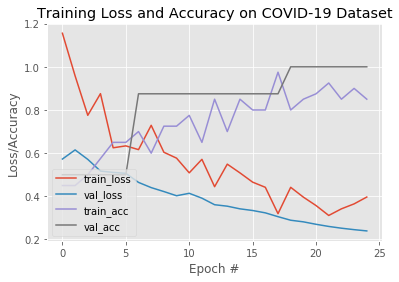

In [4]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
#model.save('covid_19.h5')